# Geodemographic Segmentation Model

In [1]:
from __future__ import division
%matplotlib inline 
import warnings
warnings.filterwarnings("ignore")

import pandas
import csv
import numpy as np
import statsmodels.api as sm
import statsmodels.discrete.discrete_model as smdis
import statsmodels.stats.outliers_influence as outliers
import matplotlib.pyplot as plt

In [2]:
df = pandas.DataFrame.from_csv('data/Churn-Modelling.csv', index_col=None)
df[:5]

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


#### Variables

- Exited: dependent variable (y) -->  is binary
- Gender, Geography: categorical independent variable (x)
- All the remaining variables: numeric independent variable (x)

In [3]:
df_y = df['Exited']
df_x = df.drop(['Exited'], axis = 1)

Create dummy variables for the categorical variables:

In [4]:
dummy = pandas.get_dummies(df_x['Gender'])
df_x = dummy.join(df_x)
dummy = pandas.get_dummies(df_x['Geography'])
df_x = dummy.join(df_x)
df_x[:5]

,France,Germany,Spain,Female,Male,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,1,0,0,1,0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88
1,0,0,1,1,0,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,1,0,0,1,0,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,1,0,0,1,0,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63
4,0,0,1,1,0,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10


Only one dummy variable should be used to avoid the "dummy variable trap":

In [5]:
df_x = df_x.drop(['Gender', 'Male', 'France', 'Geography'], axis =1)
df_x[:5]

,Germany,Spain,Female,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,0,0,1,1,15634602,Hargrave,619,42,2,0.00,1,1,1,101348.88
1,0,1,1,2,15647311,Hill,608,41,1,83807.86,1,0,1,112542.58
2,0,0,1,3,15619304,Onio,502,42,8,159660.80,3,1,0,113931.57
3,0,0,1,4,15701354,Boni,699,39,1,0.00,2,0,0,93826.63
4,0,1,1,5,15737888,Mitchell,850,43,2,125510.82,1,1,1,79084.10


Add a constant \begin{align} b_0 \end{align} to the model:

In [6]:
df_x = sm.add_constant(df_x)
df_x[:2]

,const,Germany,Spain,Female,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,1.0,0,0,1,1,15634602,Hargrave,619,42,2,0.00,1,1,1,101348.88
1,1.0,0,1,1,2,15647311,Hill,608,41,1,83807.86,1,0,1,112542.58


Exclude the variables that should not affect the model:

In [7]:
df_x = df_x.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1)
df_x[:2]

,const,Germany,Spain,Female,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,1.0,0,0,1,619,42,2,0.00,1,1,1,101348.88
1,1.0,0,1,1,608,41,1,83807.86,1,0,1,112542.58


Create a model with all the remaining variables:

In [8]:
model1 = smdis.Logit(df_y, df_x).fit()
print (model1.summary())
print ("\n_____P-values____")
p = model1.pvalues
print (p)
print ("\n_____Highest p-value____")
print ("\n %s \n" % p[p ==max(p)])
print ("\n____Confusion Matrix___")
cm = model1.pred_table()
print (cm)
print ("\nNumber of cases correctly predicted: %s (%s %%)" % (cm[0][0] + cm[1][1], (cm[0][0] + cm[1][1])*100/np.sum(cm)))

Optimization terminated successfully.
         Current function value: 0.428068
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 Exited   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9988
Method:                           MLE   Df Model:                           11
Date:                Fri, 26 Jun 2020   Pseudo R-squ.:                  0.1532
Time:                        18:52:28   Log-Likelihood:                -4280.7
converged:                       True   LL-Null:                       -5054.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -3.9208      0.245    -15.980      0.000      -4.402      -3.440
Germany       

Note: 

__"Pseudo R-squ."__ -  pseudo R-squared. 
Logistic regression does not have an equivalent to the R-squared that is found in OLS regression; however, many people have tried to come up with one.  There are a wide variety of pseudo-R-square statistics.  Because this statistic does not mean what R-square means in OLS regression (the proportion of variance explained by the predictors), we suggest interpreting this statistic with great caution.        (source: http://www.ats.ucla.edu/stat/stata/output/stata_logistic.htm) 



__Backward Elimination__

New model without the variable with the highest p-value: "Spain"

In [9]:
df_x1 = df_x.drop(['Spain'], axis = 1)
df_x1[:2]

,const,Germany,Female,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,1.0,0,1,619,42,2,0.00,1,1,1,101348.88
1,1.0,0,1,608,41,1,83807.86,1,0,1,112542.58


In [10]:
model2 = smdis.Logit(df_y, df_x1).fit()
print (model2.summary())
print ("\n_____P-values____")
p = model2.pvalues
print (p)
print ("\n_____Highest p-value____")
print ("\n %s \n" % p[p ==max(p)])
print ("\n____Confusion Matrix___")
cm = model2.pred_table()
print (cm)
print ("\nNumber of cases correctly predicted: %s (%s %%)" % (cm[0][0] + cm[1][1], (cm[0][0] + cm[1][1])*100/np.sum(cm)))

Optimization terminated successfully.
         Current function value: 0.428080
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 Exited   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9989
Method:                           MLE   Df Model:                           10
Date:                Fri, 26 Jun 2020   Pseudo R-squ.:                  0.1531
Time:                        18:52:28   Log-Likelihood:                -4280.8
converged:                       True   LL-Null:                       -5054.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -3.9110      0.245    -15.994      0.000      -4.390      -3.432
Germany       

New model without the variable with the highest p-value: "HasCrCard"

In [11]:
df_x2 = df_x1.drop(['HasCrCard'], axis = 1)
df_x2[:2]

,const,Germany,Female,CreditScore,Age,Tenure,Balance,NumOfProducts,IsActiveMember,EstimatedSalary
0,1.0,0,1,619,42,2,0.00,1,1,101348.88
1,1.0,0,1,608,41,1,83807.86,1,1,112542.58


In [12]:
model3 = smdis.Logit(df_y, df_x2).fit()
print (model3.summary())
print ("\n_____P-values____")
p = model3.pvalues
print (p)
print ("\n_____Highest p-value____")
print ("\n %s \n" % p[p ==max(p)])
print ("\n____Confusion Matrix___")
cm = model3.pred_table()
print (cm)
print ("\nNumber of cases correctly predicted: %s (%s %%)" % (cm[0][0] + cm[1][1], (cm[0][0] + cm[1][1])*100/np.sum(cm)))

Optimization terminated successfully.
         Current function value: 0.428109
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 Exited   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9990
Method:                           MLE   Df Model:                            9
Date:                Fri, 26 Jun 2020   Pseudo R-squ.:                  0.1531
Time:                        18:52:28   Log-Likelihood:                -4281.1
converged:                       True   LL-Null:                       -5054.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -3.9444      0.241    -16.395      0.000      -4.416      -3.473
Germany       

New model without the variable with the highest p-value: "EstimatedSalary"

In [13]:
df_x3 = df_x2.drop(['EstimatedSalary'], axis = 1)
df_x3[:2]

,const,Germany,Female,CreditScore,Age,Tenure,Balance,NumOfProducts,IsActiveMember
0,1.0,0,1,619,42,2,0.00,1,1
1,1.0,0,1,608,41,1,83807.86,1,1


In [14]:
model4 = smdis.Logit(df_y, df_x3).fit()
print (model4.summary())
print ("\n_____P-values____")
p = model4.pvalues
print (p)
print ("\n_____Highest p-value____")
print ("\n %s \n" % p[p ==max(p)])
print ("\n____Confusion Matrix___")
cm = model4.pred_table()
print (cm)
print ("\nNumber of cases correctly predicted: %s (%s %%)" % (cm[0][0] + cm[1][1], (cm[0][0] + cm[1][1])*100/np.sum(cm)))

Optimization terminated successfully.
         Current function value: 0.428161
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 Exited   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9991
Method:                           MLE   Df Model:                            8
Date:                Fri, 26 Jun 2020   Pseudo R-squ.:                  0.1530
Time:                        18:52:28   Log-Likelihood:                -4281.6
converged:                       True   LL-Null:                       -5054.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -3.8959      0.236    -16.528      0.000      -4.358      -3.434
Germany          

New model without the variable with the highest p-value: "Tenure"

In [15]:
df_x4 = df_x3.drop(['Tenure'], axis = 1)
df_x4[:2]

,const,Germany,Female,CreditScore,Age,Balance,NumOfProducts,IsActiveMember
0,1.0,0,1,619,42,0.00,1,1
1,1.0,0,1,608,41,83807.86,1,1


In [16]:
model5 = smdis.Logit(df_y, df_x4).fit()
print (model5.summary())
print ("\n_____P-values____")
p = model5.pvalues
print (p)
print ("\n_____Highest p-value____")
print ("\n %s \n" % p[p ==max(p)])
print ("\n____Confusion Matrix___")
cm = model5.pred_table()
print (cm)
print ("\nNumber of cases correctly predicted: %s (%s %%)" % (cm[0][0] + cm[1][1], (cm[0][0] + cm[1][1])*100/np.sum(cm)))

Optimization terminated successfully.
         Current function value: 0.428307
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 Exited   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9992
Method:                           MLE   Df Model:                            7
Date:                Fri, 26 Jun 2020   Pseudo R-squ.:                  0.1527
Time:                        18:52:28   Log-Likelihood:                -4283.1
converged:                       True   LL-Null:                       -5054.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -3.9760      0.231    -17.200      0.000      -4.429      -3.523
Germany          

Since the Accuracy decreases, the variable "Tenure" should be used in the model. 
Now, the variable with the highest p-value is "NumOfProducts" with 0.032, which is above of the defined threshold - 0.05.  

In [17]:
df_x3[:5]

,const,Germany,Female,CreditScore,Age,Tenure,Balance,NumOfProducts,IsActiveMember
0,1.0,0,1,619,42,2,0.00,1,1
1,1.0,0,1,608,41,1,83807.86,1,1
2,1.0,0,1,502,42,8,159660.80,3,0
3,1.0,0,1,699,39,1,0.00,2,0
4,1.0,0,1,850,43,2,125510.82,1,1


#### Transforming Independent Variables

Most common transformations:

1. $$\sqrt{x}$$
2. $$x^2$$
3. $$ln(x)$$

Transform "Balance" variable with ln(x):

Original value: Balance (in 1000$):

        Bal2 = Bal1 + 1unit -->  Bal2 = Bal1 + 1000$
        
        Scenario1: Bal1 = 1000$
            --> Bal2 = 1000$ + 1000$ = 2000$
        Scenario2: Bal1 = 10000$
            --> Bal2 = 10000$ + 1000$ = 11000$
          
Log10(Balance + 1):

        log10(Bal2) = log10(Bal1) + 1unit --> Bal2 = Bal1*10
        
        Scenario1: Bal1 = 1000$
            --> Bal2 = 1000*10 = 10000
    Scenario2: Bal1 = 10000$
            ---> Bal2 = 10000*10 = 100000
            
Using the original value, means that if someone that starts with a balance of 1000$ and has an increase of 1000$, and someone that starts with a balance of 10000$ and has the same amount of increasing, are two completly different things.

Using the ln transformation, it has the same affect on any person regardless of their starting point. It always a 10 times increase so a unit increase has a consistent increase in the balance variable which is 10 times.

So regardless of who we're segmenting we can say that the effect of a one unit increase in the new transformed variable is consistent throughout our population and that is much more powerful because that does not restrict the logistic regression.
        

In [18]:
df_x4 = df_x3
df_x4['Balance_log'] = df_x4['Balance'].map(lambda x: np.log10(x+1))
df_x4[:2]

,const,Germany,Female,CreditScore,Age,Tenure,Balance,NumOfProducts,IsActiveMember,Balance_log
0,1.0,0,1,619,42,2,0.00,1,1,0.00000
1,1.0,0,1,608,41,1,83807.86,1,1,4.92329


In [19]:
model6 = smdis.Logit(df_y, df_x4).fit()
print (model6.summary())
print ("\n_____P-values____")
p = model6.pvalues
print (p)
print ("\n_____Highest p-value____")
print ("\n %s \n" % p[p ==max(p)])
print ("\n____Confusion Matrix___")
cm = model6.pred_table()
print (cm)
print ("\nNumber of cases correctly predicted: %s (%s %%)" % (cm[0][0] + cm[1][1], (cm[0][0] + cm[1][1])*100/np.sum(cm)))

Optimization terminated successfully.
         Current function value: 0.428134
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 Exited   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9990
Method:                           MLE   Df Model:                            9
Date:                Fri, 26 Jun 2020   Pseudo R-squ.:                  0.1530
Time:                        18:52:28   Log-Likelihood:                -4281.3
converged:                       True   LL-Null:                       -5054.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -3.9147      0.237    -16.505      0.000      -4.380      -3.450
Germany          

The accuracy is improved!

#### Derived Variables

Sometimes it is useful too account for some effects, for example in our case, the balance and age might be correlated, because the older a person is the more whealth he/she can accumulate. 

So a new variable can be created:

$$WealthAccumlation = \frac{Balance}{Age}$$

In [20]:
df_x5 = df_x4
df_x5['WealthAccumulation'] = df_x5['Balance']/ df_x5['Age']
df_x5[:2]

,const,Germany,Female,CreditScore,Age,Tenure,Balance,NumOfProducts,IsActiveMember,Balance_log,WealthAccumulation
0,1.0,0,1,619,42,2,0.00,1,1,0.00000,0.000000
1,1.0,0,1,608,41,1,83807.86,1,1,4.92329,2044.094146


In [21]:
model7 = smdis.Logit(df_y, df_x5).fit()
print (model7.summary())
print ("\n_____P-values____")
p = model7.pvalues
print (p)
print ("\n_____Highest p-value____")
print ("\n %s \n" % p[p ==max(p)])
print ("\n____Confusion Matrix___")
cm = model7.pred_table()
print (cm)
print ("\nNumber of cases correctly predicted: %s (%s %%)" % (cm[0][0] + cm[1][1], (cm[0][0] + cm[1][1])*100/np.sum(cm)))

Optimization terminated successfully.
         Current function value: 0.427323
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 Exited   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9989
Method:                           MLE   Df Model:                           10
Date:                Fri, 26 Jun 2020   Pseudo R-squ.:                  0.1546
Time:                        18:52:28   Log-Likelihood:                -4273.2
converged:                       True   LL-Null:                       -5054.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -3.4253      0.266    -12.896      0.000      -3.946      -2.905
Germa

This new variable had a negative effect in the model accuracy.

However, one should have in consideration that might be some collinearity effects because wealth accumulation includes the variables balance and age that are already in the model. So basically this means that this new variable might be somehow correlated with the other two and including all of them in the model might cause some damage, so on of them should be excluded.


#### Multicollinearity

Multicollinearity is a phenomenon in which two or more predictor variables in a multiple regression model are highly correlated, meaning that one can be linearly predicted from the others with a substantial degree of accuracy.

The "Variance Inflation Factors - VIF" can be used to measure the degree of multicollinearity.

Minimum possible value = 1.0
Values > 5 may indicate a collinearity problem.

$$VIF(j) = \frac{1}{( 1 - R(j)^2)}$$

where R(j) is the multiple correlarion coefficient between variable j and the other independent variables


In [22]:
i = 0
for column in df_x5.columns:
    
    print (column + " %s" % outliers.variance_inflation_factor(df_x5.values, i))
    i += 1

const 91.47737228031622
Germany 1.2710122442115002
Female 1.0032158261260191
CreditScore 1.0010445076720837
Age 2.1048762051249206
Tenure 1.0016107315591962
Balance 20.889567366739836
NumOfProducts 1.1531246650360734
IsActiveMember 1.0138497293299344
Balance_log 8.728812029237517
WealthAccumulation 14.559859582396331


Rerun without the "Balance_log" variable:

In [23]:
df_x6 = df_x5.drop('Balance_log', axis = 1)

In [24]:
model8 = smdis.Logit(df_y, df_x6).fit()
print (model8.summary())
print ("\n_____P-values____")
p = model8.pvalues
print (p)
print ("\n_____Highest p-value____")
print ("\n %s \n" % p[p ==max(p)])
print ("\n____Confusion Matrix___")
cm = model8.pred_table()
print (cm)
print ("\nNumber of cases correctly predicted: %s (%s %%)" % (cm[0][0] + cm[1][1], (cm[0][0] + cm[1][1])*100/np.sum(cm)))

Optimization terminated successfully.
         Current function value: 0.427344
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 Exited   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9990
Method:                           MLE   Df Model:                            9
Date:                Fri, 26 Jun 2020   Pseudo R-squ.:                  0.1546
Time:                        18:52:28   Log-Likelihood:                -4273.4
converged:                       True   LL-Null:                       -5054.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -3.4089      0.264    -12.904      0.000      -3.927      -2.891
Germa

In [25]:
i = 0

for column in df_x6.columns:
    
    print (column + " %s" % outliers.variance_inflation_factor(df_x6.values, i))
    i += 1

const 90.63207750465456
Germany 1.21616765689555
Female 1.003027851735002
CreditScore 1.0009799515615998
Age 2.1047750527831988
Tenure 1.0015340612763608
Balance 14.024565340688422
NumOfProducts 1.1233022602894258
IsActiveMember 1.0135323455334948
WealthAccumulation 14.559856267949373


Create new variable log for wealth accumulation:

In [26]:
df_x7 = df_x5
df_x7['WealthAccumulation_log'] = df_x7['WealthAccumulation'].map(lambda x: np.log10(x + 1))
df_x7[:2]

,const,Germany,Female,CreditScore,Age,Tenure,Balance,NumOfProducts,IsActiveMember,Balance_log,WealthAccumulation,WealthAccumulation_log
0,1.0,0,1,619,42,2,0.00,1,1,0.00000,0.000000,0.000000
1,1.0,0,1,608,41,1,83807.86,1,1,4.92329,2044.094146,3.310713


In [27]:
df_x7 = df_x7.drop(['Balance', 'WealthAccumulation'], axis = 1)

In [28]:
model9 = smdis.Logit(df_y, df_x7).fit()
print (model9.summary())
print ("\n_____P-values____")
p = model9.pvalues
print (p)
print ("\n_____Highest p-value____")
print ("\n %s \n" % p[p ==max(p)])
print ("\n____Confusion Matrix___")
cm = model9.pred_table()
print (cm)
print ("\nNumber of cases correctly predicted: %s (%s %%)" % (cm[0][0] + cm[1][1], (cm[0][0] + cm[1][1])*100/np.sum(cm)))

Optimization terminated successfully.
         Current function value: 0.427891
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 Exited   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9990
Method:                           MLE   Df Model:                            9
Date:                Fri, 26 Jun 2020   Pseudo R-squ.:                  0.1535
Time:                        18:52:29   Log-Likelihood:                -4278.9
converged:                       True   LL-Null:                       -5054.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -3.5735      0.267    -13.362      0.000      -4.098      

In [29]:
i = 0

for column in df_x7.columns:
    
    print (column + " %s" % outliers.variance_inflation_factor(df_x7.values, i))
    i += 1

const 93.56080745313169
Germany 1.269863597353901
Female 1.002820380224349
CreditScore 1.0010294570399014
Age 2.264798389454287
Tenure 1.001654591615144
NumOfProducts 1.1524300009772472
IsActiveMember 1.0116835757905471
Balance_log 705.940971112806
WealthAccumulation_log 704.7399712732436


"Balance_log" and "WealthAccumulation_log" have too large values which means that these two variables are basically the same thing. So one of these variables must be excluded!

In [30]:
df_x8 = df_x7.drop(['Balance_log'], axis = 1)

In [31]:
model10 = smdis.Logit(df_y, df_x8).fit()
print (model10.summary())
print ("\n_____P-values____")
p = model10.pvalues
print (p)
print ("\n_____Highest p-value____")
print ("\n %s \n" % p[p ==max(p)])
print ("\n____Confusion Matrix___")
cm = model10.pred_table()
print (cm)
print ("\nNumber of cases correctly predicted: %s (%s %%)" % (cm[0][0] + cm[1][1], (cm[0][0] + cm[1][1])*100/np.sum(cm)))

Optimization terminated successfully.
         Current function value: 0.428322
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 Exited   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9991
Method:                           MLE   Df Model:                            8
Date:                Fri, 26 Jun 2020   Pseudo R-squ.:                  0.1527
Time:                        18:52:29   Log-Likelihood:                -4283.2
converged:                       True   LL-Null:                       -5054.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -3.9325      0.239    -16.467      0.000      -4.401      

Correlation between variables:

In [32]:
df_x5[['Age', 'Balance_log', 'WealthAccumulation_log', 'WealthAccumulation']].corr()

,Age,Balance_log,WealthAccumulation_log,WealthAccumulation
Age,1.000000,0.034530,-0.007524,-0.246293
Balance_log,0.034530,1.000000,0.998404,0.865141
WealthAccumulation_log,-0.007524,0.998404,1.000000,0.888872
WealthAccumulation,-0.246293,0.865141,0.888872,1.000000


As one can observe, the "WealthAccumulation_log" and "Balance_log" variables are highly correlated - they are basically the same which is very bad for the model.
 
Thumb rule: anything 0.9 is very high correlation. Correlations above 0.5 should be addressed.

In [33]:
df_final = df_x5.drop(['Balance', 'WealthAccumulation', 'WealthAccumulation_log'], axis = 1)

In [34]:
model11 = smdis.Logit(df_y, df_final).fit()
print (model11.summary())
print ("\n_____P-values____")
p = model11.pvalues
print (p)
print ("\n_____Highest p-value____")
print ("\n %s \n" % p[p ==max(p)])
print ("\n____Confusion Matrix___")
cm = model11.pred_table()
print (cm)
print ("\nNumber of cases correctly predicted: %s (%s %%)" % (cm[0][0] + cm[1][1], (cm[0][0] + cm[1][1])*100/np.sum(cm)))

Optimization terminated successfully.
         Current function value: 0.428257
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 Exited   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9991
Method:                           MLE   Df Model:                            8
Date:                Fri, 26 Jun 2020   Pseudo R-squ.:                  0.1528
Time:                        18:52:29   Log-Likelihood:                -4282.6
converged:                       True   LL-Null:                       -5054.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -3.9126      0.237    -16.497      0.000      -4.377      -3.448
Germany          

In [35]:
i = 0

for column in df_final.columns:
    
    print (column + " %s" % outliers.variance_inflation_factor(df_final.values, i))
    i += 1

const 76.39366341718306
Germany 1.2693438952831235
Female 1.0028146589372542
CreditScore 1.0010220469271618
Age 1.0117154799275245
Tenure 1.0014367308031957
NumOfProducts 1.151455970178528
IsActiveMember 1.0102802651126976
Balance_log 1.4200701431300486


Now, none of the variables presents multicollinearity.

#### CAP - Cumulative Accuracy Profile Curve

In [36]:
df_cap = df[['RowNumber', 'Exited']]
df_cap['phat'] = model11.predict()

In [37]:
df_cap['phat'].sort_values(ascending=False)[:5]

4815    0.930669
3531    0.928311
9587    0.923303
7499    0.906178
9555    0.904457
Name: phat, dtype: float64

In [38]:
Total_Exited = sum(df_cap['Exited'])
print ("Total Exited: %s" % Total_Exited)
Total_Records = len(df)
print ("Total number of clients: %s" % Total_Records)
Exit_Ratio = Total_Exited/Total_Records
print ("Ratio of exits: %s " % Exit_Ratio)

Total Exited: 2037
Total number of clients: 10000
Ratio of exits: 0.2037 


First, I select the clients that have a higher probability.

In [39]:
df_cap['total_selected'] = range(1,len(df_cap)+1)
df_cap['total_selected_per'] = df_cap['total_selected'].map(lambda x: round(x*100/Total_Records, 1))
df_cap['random_selection'] = df_cap['total_selected'].map(lambda x: x*Exit_Ratio)
df_cap['random_selection_per'] = df_cap['total_selected'].map(lambda x: round(x*100/Total_Records, 1))

In [40]:
df_cap = df_cap.sort_values(by=['phat'],ascending=False)[:5]

In [41]:
df_cap['model_select'] = df_cap.Exited.cumsum()
df_cap['model_select_per'] = df_cap['model_select'].map(lambda x: round(x*100/Total_Exited, 1))

In [42]:
df_cap[:5]

,RowNumber,Exited,phat,total_selected,total_selected_per,random_selection,random_selection_per,model_select,model_select_per
4815,4816,0,0.930669,4816,48.2,981.0192,48.2,0,0.0
3531,3532,1,0.928311,3532,35.3,719.4684,35.3,1,0.0
9587,9588,0,0.923303,9588,95.9,1953.0756,95.9,1,0.0
7499,7500,1,0.906178,7500,75.0,1527.7500,75.0,2,0.1
9555,9556,1,0.904457,9556,95.6,1946.5572,95.6,3,0.1


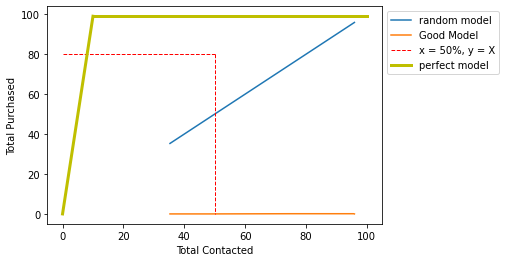

In [43]:
df_cap = df_cap.sort_values(by=['RowNumber'])
plt.plot(df_cap['total_selected_per'], df_cap['random_selection_per'], label = 'random model' )
plt.plot(df_cap['total_selected_per'], df_cap['model_select_per'], label = 'Good Model' )
plt.plot([50, 50], [80, 0], 'r--', lw=1, label = 'x = 50%, y = X')
plt.plot([0, 50], [80, 80], 'r--', lw=1)
plt.plot([10, 100], [99, 99], 'y-', lw=3, label = 'perfect model')
plt.plot([0, 10], [0, 99], 'y-', lw=3)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.xlabel('Total Contacted')
plt.ylabel('Total Purchased')
plt.show()

The closer the green line is to the yellow line, the better the model. The closer to the blue line, the worse. 

__Accuracy Ratio__:
    - Take the area under the perfect model (yellow line) to the random model (blue line) - 
$$a_p$$
    - Take the area under the good model (green line) to the random model (blue line) - 
    
$$a_r$$
    - So the accuracy ratio:
    
$$AR = \frac{a_r}{a_p}$$

that is between 0 and 1, and the closer the ratio is to 1 the better.

__Rule of thumb:__

Another way of evaluating the model is to look to the red line, x = 50%, and y = X:

If:

    90% < X < 100% -> Too Good (overfitting?)
    80% < X < 90% -> Very Good
    70% < X < 80% -> Good
    60% < X < 70% -> Poor
    X < 60% -> Rubbish

#### Test model with test data

In [44]:
df_test = pandas.DataFrame.from_csv('data/Churn-Modelling-Test-Data.csv', index_col=None)
df_test[:5]

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,10001,15798485,Copley,565,France,Male,31,1,0.00,1,0,1,20443.08,0
1,10002,15588959,T'ang,569,France,Male,34,4,0.00,1,0,1,4045.90,0
2,10003,15624896,Ku,669,France,Female,20,7,0.00,2,1,0,128838.67,0
3,10004,15639629,McConnan,694,France,Male,39,4,173255.48,1,1,1,81293.10,0
4,10005,15638852,Ts'ui,504,Spain,Male,28,10,109291.36,1,1,1,187593.15,0


In [45]:
df_test = sm.add_constant(df_test)

In [46]:
df_test_y = df_test['Exited']
df_test = df_test.drop(['Exited'], axis = 1)

In [47]:
dummy = pandas.get_dummies(df_test['Gender'])
df_test= dummy.join(df_test)
dummy = pandas.get_dummies(df_test['Geography'])
df_test = dummy.join(df_test)
df_test[:5]

,France,Germany,Spain,Female,Male,const,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,1,0,0,0,1,1.0,10001,15798485,Copley,565,France,Male,31,1,0.00,1,0,1,20443.08
1,1,0,0,0,1,1.0,10002,15588959,T'ang,569,France,Male,34,4,0.00,1,0,1,4045.90
2,1,0,0,1,0,1.0,10003,15624896,Ku,669,France,Female,20,7,0.00,2,1,0,128838.67
3,1,0,0,0,1,1.0,10004,15639629,McConnan,694,France,Male,39,4,173255.48,1,1,1,81293.10
4,0,0,1,0,1,1.0,10005,15638852,Ts'ui,504,Spain,Male,28,10,109291.36,1,1,1,187593.15


In [48]:
df_test['Balance_log'] = df_test['Balance'].map(lambda x: np.log10(x+1))

Check the parameters included in the final model (model11) and rerun the model with the same parameters but now including the test data:

In [49]:
model11.params

const            -3.912576
Germany           0.747595
Female            0.526721
CreditScore      -0.000675
Age               0.072655
Tenure           -0.015879
NumOfProducts    -0.095020
IsActiveMember   -1.075776
Balance_log       0.069026
dtype: float64

In [50]:
df_test = df_test[['Germany', 'Female', 'CreditScore', 'Age', 'Tenure', 'NumOfProducts', 'IsActiveMember', 'Balance_log', 'const']]

In [51]:
df_total = df_final.append(df_test)

In [52]:
model_final = smdis.Logit(df_y, df_total[:10000]).fit()

Optimization terminated successfully.
         Current function value: 0.428257
         Iterations 6


In [53]:
y_pred = model_final.predict(df_total[10000:])
y_pred[:5]

0    0.038117
1    0.044761
2    0.063838
3    0.081653
4    0.039160
dtype: float64

Let's construct the CAP curve:

In [54]:
df_pred = pandas.DataFrame()
df_pred['phat'] = y_pred
df_pred['Exited'] = df_test_y
df_pred = df_pred.sort_values(by=['phat'], ascending=False)
df_pred[:5]

,phat,Exited
957,0.877614,1
249,0.857731,1
429,0.832754,1
209,0.826484,1
693,0.826381,0


In [55]:
Total_Exited = sum(df_pred['Exited'])
print ("Total Exited: %s" % Total_Exited)
Total_Records = len(df_pred)
print ("Total number of clients: %s" % Total_Records)
Exit_Ratio = Total_Exited/Total_Records
print ("Ratio of exits: %s" % Exit_Ratio)

Total Exited: 260
Total number of clients: 1000
Ratio of exits: 0.26


In [56]:
df_pred['total_selected'] = range(1,len(df_pred)+1)
df_pred['total_selected_per'] = df_pred['total_selected'].map(lambda x: round(x*100/Total_Records, 1))
df_pred['random_selection'] = df_pred['total_selected'].map(lambda x: x*Exit_Ratio)
df_pred['random_selection_per'] = df_pred['total_selected'].map(lambda x: round(x*100/Total_Records, 1))

In [57]:
df_pred = df_pred.sort_values(by=['phat'], ascending=False)

In [58]:
df_pred['model_select'] = df_pred.Exited.cumsum()
df_pred['model_select_per'] = df_pred['model_select'].map(lambda x: round(x*100/Total_Exited, 1))

In [59]:
df_pred[:5]

,phat,Exited,total_selected,total_selected_per,random_selection,random_selection_per,model_select,model_select_per
957,0.877614,1,1,0.1,0.26,0.1,1,0.4
249,0.857731,1,2,0.2,0.52,0.2,2,0.8
429,0.832754,1,3,0.3,0.78,0.3,3,1.2
209,0.826484,1,4,0.4,1.04,0.4,4,1.5
693,0.826381,0,5,0.5,1.30,0.5,4,1.5


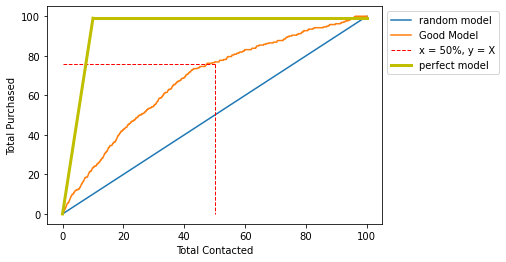

In [60]:
plt.plot(df_pred['total_selected_per'], df_pred['random_selection_per'], label = 'random model' )
plt.plot(df_pred['total_selected_per'], df_pred['model_select_per'], label = 'Good Model' )
plt.plot([50, 50], [76, 0], 'r--', lw=1, label = 'x = 50%, y = X')
plt.plot([0, 50], [76, 76], 'r--', lw=1)
plt.plot([10, 100], [99, 99], 'y-', lw=3, label = 'perfect model')
plt.plot([0, 10], [0, 99], 'y-', lw=3)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.xlabel('Total Contacted')
plt.ylabel('Total Purchased')
plt.show()

__Conclusions__:

- The model is performing above 80%, so a bit worse than the training data (a drop of about 3%).
- The concentration of data is about 10 times less than the training data which explains the ruggedness of the curve.

### Parameters Interpretation

Odds ratio:

$$odds = \frac{p}{1-p}$$

Multiple logistic regression:

$$ln(\frac{p}{1-p}) = b_0 + b_0x_1 + ... + b_nx_n$$

So we can write:

$$ln(odds) = b_0 + b_0x_1 + ... + b_nx_n$$

$$<=> odds = e^{b_0 + b_0x_1 + ... + b_nx_n}$$

$$<=> odds = e^{b_0} + e^{b_0x_1} + ... + e^{b_nx_n}$$

which means that, if we increase an unit to the $$x_1$$ variable,  for example:

$$e^{b_1x_1} -> e^{b_1(x_1 + 1)} = e^{b_1x_1}e^{b_1}$$

which means that, increading an independente variable, e.g. $$x_1$$, by 1 unit, will increase the odds by a multiplicative factor of $$e^{b_i}$$

So let's transform the coefficients of our model into odds ratios:



In [61]:
odds_ratio = np.exp(model_final.params)
odds_ratio

Age               1.075360
Balance_log       1.071464
CreditScore       0.999325
Female            1.693371
Germany           2.111916
IsActiveMember    0.341033
NumOfProducts     0.909355
Tenure            0.984246
const             0.019989
dtype: float64

- "Germany" has the greater odds ratio, which means that being in Germany has the highest impact for people leaving the bank - most important independent variable that influences the model. If we change from not Germany to Germany, the odds ratio increases by 2.1.
- The next one is gender. One we go from a male customer to a female customer with all else held constant, the odds ratio of a female custormer leaving is 1.7 times grater that a Male customer leaving. So basically the odds ratio increases by 70%.
- Being an "ActiveMember" has the oppositive effect because the value is less than 1. This means that when we go from a member who is not active to a member that is active, the odds ratio gets multiplied by 0.34. So basically it drops by 66% which is also great in terms of retention.
- Anything above 0.8 and bellow 1.2 has not a great impact and can be ignored.
